In [1]:
# Install required libraries
!pip install tensorflow scikit-learn seaborn

# Import necessary libraries
import numpy as np
from tensorflow.keras.datasets import mnist
from tensorflow.keras.applications import VGG19
from tensorflow.keras.models import Model
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
# Load MNIST dataset (only taking first channel to match VGG19 input size)
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Convert grayscale images to 3-channel RGB to match VGG19's input shape (224x224x3)
x_train = np.stack([x_train]*3, axis=-1)
x_test = np.stack([x_test]*3, axis=-1)

# Resize images to 32x32 to match the required input size of VGG19
x_train = np.array([np.resize(img, (32, 32, 3)) for img in x_train])
x_test = np.array([np.resize(img, (32, 32, 3)) for img in x_test])

# Normalize the images
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0


11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [3]:
# Load the VGG19 model without the top classification layers
base_model = VGG19(weights='imagenet', include_top=False, input_shape=(32, 32, 3))

# Use the output of the last convolutional layer
model = Model(inputs=base_model.input, outputs=base_model.output)

# Extract features for the training and testing data
features_train = model.predict(x_train)
features_test = model.predict(x_test)

# Flatten the features (required for feeding into SVM or any other classifier)
features_train = features_train.reshape(features_train.shape[0], -1)
features_test = features_test.reshape(features_test.shape[0], -1)

print("Training features shape:", features_train.shape)
print("Testing features shape:", features_test.shape)


80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 947s 504ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 154s 492ms/step
Training features shape: (60000, 512)
Testing features shape: (10000, 512)


In [4]:
# Function to preprocess features using StandardScaler
def preprocess_features(X):
    scaler = StandardScaler()
    X_preprocessed = scaler.fit_transform(X)
    return X_preprocessed

# Preprocess the features
X_train_preprocessed = preprocess_features(features_train)
X_test_preprocessed = preprocess_features(features_test)




In [5]:
# Function to perform PCA and reduce dimensions
def select_features_with_pca(X, n_components=100):
    pca = PCA(n_components=n_components)
    X_selected = pca.fit_transform(X)
    return X_selected, pca

# Apply PCA to reduce dimensions
X_train_pca, pca_model = select_features_with_pca(X_train_preprocessed, n_components=100)
X_test_pca = pca_model.transform(X_test_preprocessed)

print("PCA applied - Training features shape:", X_train_pca.shape)

PCA applied - Training features shape: (60000, 100)


In [6]:
# Initialize and train SVM classifier
svm_classifier = SVC(kernel='linear')
svm_classifier.fit(X_train_pca, y_train)

# Predict on the test set
y_pred_svm = svm_classifier.predict(X_test_pca)

# Calculate SVM accuracy
svm_accuracy = accuracy_score(y_test, y_pred_svm)
print("SVM Test Accuracy:", svm_accuracy)




SVM Test Accuracy: 0.8308


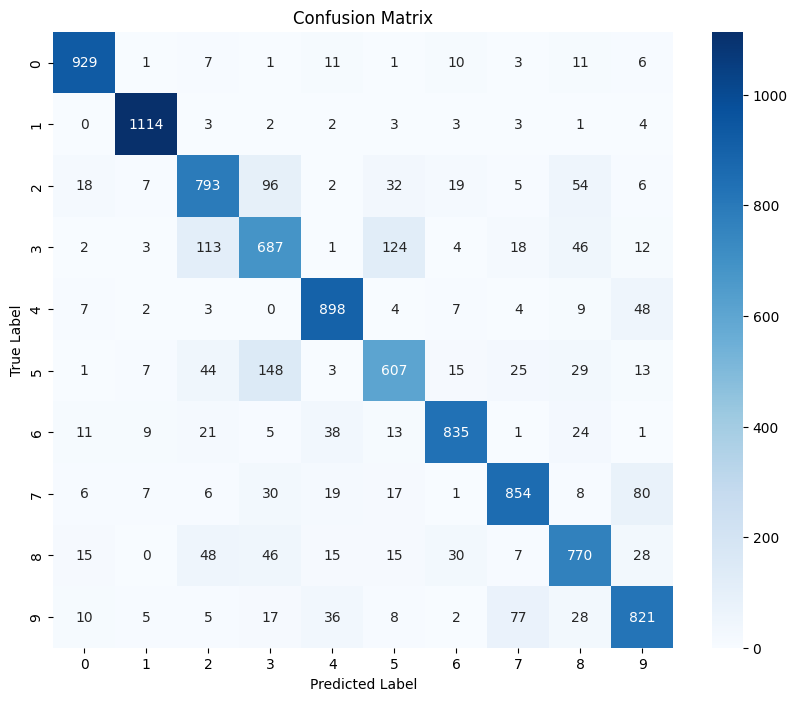

In [7]:
# Function to plot confusion matrix
def plot_confusion_matrix(y_true, y_pred):
    conf_matrix = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()

# Plot confusion matrix for SVM
plot_confusion_matrix(y_test, y_pred_svm)

In [14]:
from sklearn.metrics import f1_score

# Calculate F1 score for SVM
f1_svm = f1_score(y_test, y_pred_svm, average='macro')
print("SVM F1 Score:", f1_svm)


SVM F1 Score: 0.8278978320970719


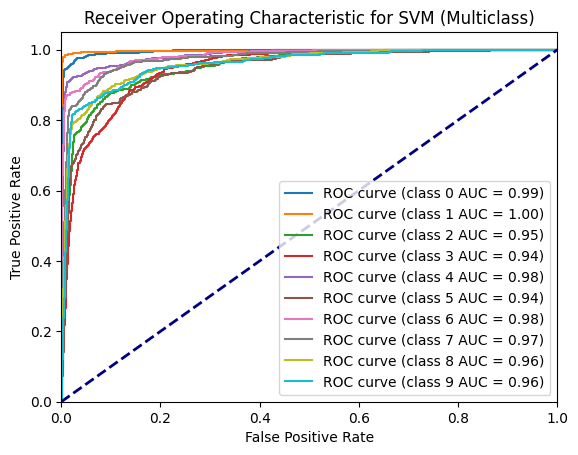

In [16]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# Binarize the output for ROC curve
y_test_bin = label_binarize(y_test, classes=np.unique(y_test))
n_classes = y_test_bin.shape[1]

# Calculate decision function scores for SVM
y_prob_svm = svm_classifier.decision_function(X_test_pca)

# Calculate ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_prob_svm[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC Curve for SVM
plt.figure()
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f'ROC curve (class {i} AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for SVM (Multiclass)')
plt.legend(loc="lower right")
plt.show()
